### Currently, this notebook is used for:
    - loading the sfMixLGN experiment data in python format
    - plotting responses

### Set up

In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)
import model_responses

% matplotlib inline 

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_style.mplstyle');

# at CNS
# dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/recordings/';
# savePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/';
# personal mac
dataPath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/structures/';
save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/figures/analyses/';

conDig = 3; # round contrast to the 3rd digit
fullWaveform = 0;

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();

In [2]:
dir = 1;

rvcFits = hf.np_smart_load(dataPath + hf.fit_name('rvcFits', dir));
phFits = hf.np_smart_load(dataPath + hf.fit_name('phaseAdvanceFits', dir));

descrFits = hf.np_smart_load(dataPath + 'descrFits_sach.npy');

### Getting the stimulus conditions

To get the stimulus conditions, just load an example cell and "tabulate" the responses

In [3]:
cellNum = 4;

In [4]:
cellStruct = hf.np_smart_load(dataPath + dataList['unitName'][cellNum-1] + '_sfm.npy');
_, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cellStruct)

In [5]:
allDisps = stimVals[0]
allCons = stimVals[1]
allSfs = stimVals[2]

### Difference of gaussian fits

In [6]:
# indices in the dog_sach model
ind_gain_c = 0;
ind_rad_c = 1;
ind_gain_s = 2;
ind_rad_s = 3;

First, analyze how much variance is explained by each model fit. This analysis is described in Cavanaugh-Heeger-Movshon (1997), and is as follows: $\%variance = 100 * [1-d(m, \overline{r})/d(\overline{r}, \overline{\overline{r}})]$, with $m :=$ model prediction, $\overline{r} :=$ mean response (per condition), and $\overline{\overline{r}} :=$ mean response over all conditions.

Futher, $d(x, y) := \dfrac{1}{N} \Sigma_s{(x_s - y_x)^2}$, where $s :=$ each condition, and $N :=$ the number of conditions.

This analysis has been moved to helper_fcns, and is attached now to the params/NLL in the descrFits structure/analysis

Let's gather some basic properties of the descriptive gaussian fits

In [305]:
all_params = [descrFits[x]['params'][0] for x in descrFits]
flat_params = np.asarray(hf.flatten(all_params))
all_varExpl = [descrFits[x]['varExpl'][0] for x in descrFits]
flat_varExpl = np.asarray(hf.flatten(all_varExpl));
all_prefSf = [descrFits[x]['prefSf'][0] for x in descrFits]
flat_prefSf = np.asarray(hf.flatten(all_varExpl));
all_NLL = [descrFits[x]['NLL'][0] for x in descrFits]
flat_NLL = np.asarray(hf.flatten(all_NLL));

n_cells = len(all_params);
n_cons = len(all_params[0]);

In [8]:
thresh_varExpl = 65; # i.e. what is the threshold for variance explained for counting that fit/params in the analysis?
valid_inds = np.where(flat_varExpl > thresh_varExpl)[0]

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


Now, gather the indices for all valid (i.e. supra-variance-explained-threshold) conditions

In [9]:
gain_c = [x[ind_gain_c] for x in flat_params[valid_inds]]
gain_s = [x[ind_gain_s] for x in flat_params[valid_inds]]

gain_ratio = np.divide(gain_c, gain_s);

# radius
rad_c = [x[ind_rad_c] for x in flat_params[valid_inds]]
rad_s = [x[ind_rad_s] for x in flat_params[valid_inds]]

rad_ratio = np.divide(rad_c, rad_s);

In [776]:
''' To be used if analyzing all parameter values (i.e. not flattened/subsetted)
# gain
gain_c = [[x[ind_gain_c] for x in c] for c in all_params]
gain_s = [[x[ind_gain_s] for x in c] for c in all_params]

gain_ratio = np.divide(gain_c, gain_s);
gain_ratio = gain_ratio[~np.isnan(gain_ratio)]

# frequency
freq_c = [[x[ind_freq_c] for x in c] for c in all_params]
freq_s = [[x[ind_freq_s] for x in c] for c in all_params]

freq_ratio = np.divide(freq_c, freq_s);
freq_ratio = freq_ratio[~np.isnan(freq_ratio)]
'''

' To be used if analyzing all parameter values (i.e. not flattened/subsetted)\n# gain\ngain_c = [[x[ind_gain_c] for x in c] for c in all_params]\ngain_s = [[x[ind_gain_s] for x in c] for c in all_params]\n\ngain_ratio = np.divide(gain_c, gain_s);\ngain_ratio = gain_ratio[~np.isnan(gain_ratio)]\n\n# frequency\nfreq_c = [[x[ind_freq_c] for x in c] for c in all_params]\nfreq_s = [[x[ind_freq_s] for x in c] for c in all_params]\n\nfreq_ratio = np.divide(freq_c, freq_s);\nfreq_ratio = freq_ratio[~np.isnan(freq_ratio)]\n'

In [10]:
print('Of %d gain ratios, %.1f%% are greater than 1 (i.e. c > s)\n' % (len(gain_ratio), 100*sum(gain_ratio>1)/len(gain_ratio)))
print('Of %d radius ratios, %.1f%% are greater than 1 (i.e. c > s)\n' % (len(rad_ratio), 100*sum(rad_ratio>1)/len(rad_ratio)))

Of 225 gain ratios, 92.9% are greater than 1 (i.e. c > s)

Of 225 radius ratios, 4.9% are greater than 1 (i.e. c > s)



Now, let's plot the trajectory of each parameter (and peak SF) with contrast, as split by cell

In [720]:
all_rc = np.nan * np.zeros((n_cells, n_cons));
all_rs = np.nan * np.zeros((n_cells, n_cons));
all_gc = np.nan * np.zeros((n_cells, n_cons));
all_gs = np.nan * np.zeros((n_cells, n_cons));
all_psf = np.nan * np.zeros((n_cells, n_cons));
all_volc = np.nan * np.zeros((n_cells, n_cons));
all_vols = np.nan * np.zeros((n_cells, n_cons));
all_volrat = np.nan * np.zeros((n_cells, n_cons));

# and make space for normalized values of the same, where we normalize to the parameter value at the highest valid contrast
all_rc_norm = np.nan * np.zeros((n_cells, n_cons));
all_rs_norm = np.nan * np.zeros((n_cells, n_cons));
all_gc_norm = np.nan * np.zeros((n_cells, n_cons));
all_gs_norm = np.nan * np.zeros((n_cells, n_cons));
all_psf_norm = np.nan * np.zeros((n_cells, n_cons));
all_volc_norm = np.nan * np.zeros((n_cells, n_cons));
all_vols_norm = np.nan * np.zeros((n_cells, n_cons));
all_volrat_norm = np.nan * np.zeros((n_cells, n_cons));

# and contrast ratios...
all_rc_conRat = np.nan * np.zeros((n_cells, ))
all_rs_conRat = np.nan * np.zeros((n_cells, ))
all_volc_conRat = np.nan * np.zeros((n_cells, ))
all_vols_conRat = np.nan * np.zeros((n_cells, ))

In [721]:
# here, organize and compute everything we need
for i in range(n_cells):
    # messy list comprehension, but basically only get the parameter if that fit meets the variance explained thresh
    all_rc[i, :] = [all_params[i][c][ind_rad_c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in range(n_cons)]
    all_rs[i, :] = [all_params[i][c][ind_rad_s] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in range(n_cons)]
    all_gc[i, :] = [all_params[i][c][ind_gain_c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in range(n_cons)]
    all_gs[i, :] = [all_params[i][c][ind_gain_s] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in range(n_cons)]
    all_psf[i, :] = [all_prefSf[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in range(n_cons)]
    # now compute volumes, ratio of volumes
    all_volc[i, :] = np.multiply(all_gc[i, :], np.square(all_rc[i, :]))
    all_vols[i, :] = np.multiply(all_gs[i, :], np.square(all_rs[i, :]))
    all_volrat[i, :] = np.divide(all_vols[i, :], all_volc[i, :])
    
    if np.all(np.isnan(all_rc[i, :])): # don't normalize if they're all NaN
        continue;
    highest_valIndex = np.where(~np.isnan(all_rc[i, :]))[0][-1];
    lowest_valIndex = np.where(~np.isnan(all_rc[i, :]))[0][0];
    all_rc_norm[i, :] = np.divide(all_rc[i, :], all_rc[i, highest_valIndex]);
    all_rs_norm[i, :] = np.divide(all_rs[i, :], all_rs[i, highest_valIndex]);
    all_gc_norm[i, :] = np.divide(all_gc[i, :], all_gc[i, highest_valIndex]);
    all_gs_norm[i, :] = np.divide(all_gs[i, :], all_gs[i, highest_valIndex]);
    all_psf_norm[i, :] = np.divide(all_psf[i, :], all_psf[i, highest_valIndex]) 
    # now compute volumes, ratio of volumes
    all_volc_norm[i, :] = np.divide(all_volc[i, :], all_volc[i, highest_valIndex])
    all_vols_norm[i, :] = np.divide(all_vols[i, :], all_vols[i, highest_valIndex])
    all_volrat_norm[i, :] = np.divide(all_volrat[i, :], all_volrat[i, highest_valIndex])

    # measure ratio of center, surround radii at highest/lowest contrast; same for volumes
    all_rc_conRat[i] = all_rc[i, highest_valIndex]/all_rc[i, lowest_valIndex];
    all_rs_conRat[i] = all_rs[i, highest_valIndex]/all_rs[i, lowest_valIndex];
    all_volc_conRat[i] = all_volc[i, highest_valIndex]/all_volc[i, lowest_valIndex];
    all_vols_conRat[i] = all_vols[i, highest_valIndex]/all_vols[i, lowest_valIndex];

#### Parameter trends versus contrast

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


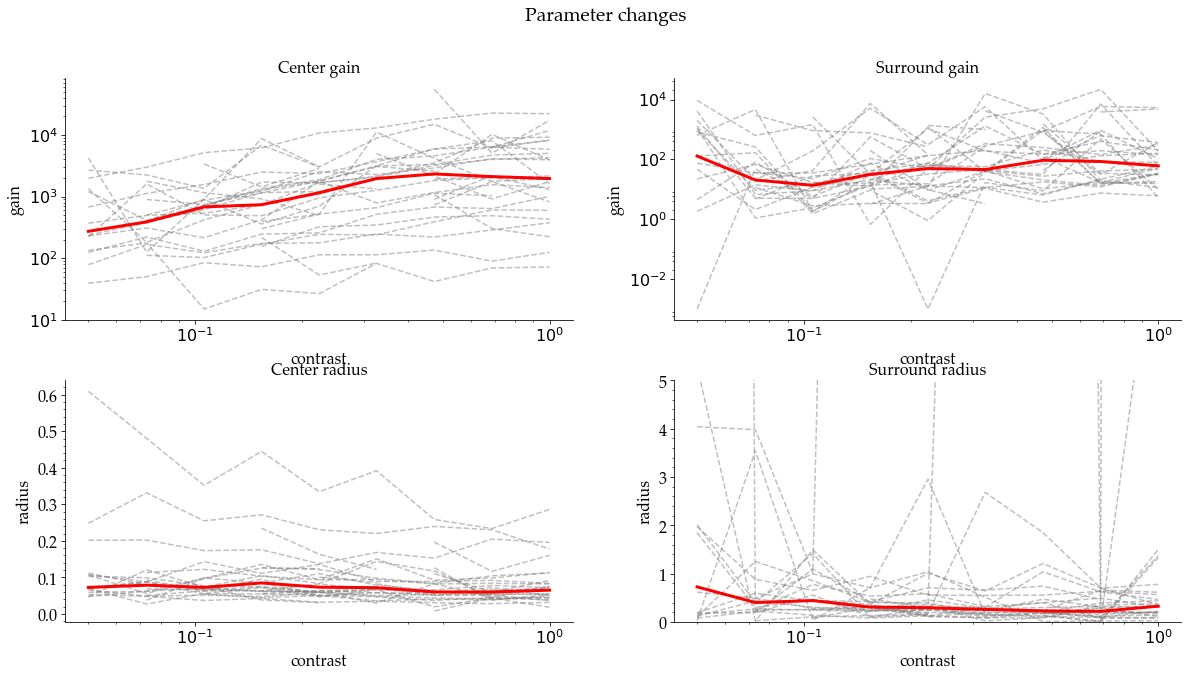

In [734]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

gray = cm.gray(0.5) # mean gray

# center gain
plt.subplot(2, 2, 1);
con_inds = np.where(~np.isnan(all_gc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_gc[i, con_inds][0], '--', color=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc, 0);
plt.plot(val_cons, gc_medians[con_inds], 'r', linewidth=3)
# plt.ylim([0, 75])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# surround gain
plt.subplot(2, 2, 2);
con_inds = np.where(~np.isnan(all_gs[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_gs[i, con_inds][0], '--', color=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs, 0);
plt.plot(val_cons, gs_medians[con_inds], 'r', linewidth=3)
# plt.ylim([0, 35])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Surround gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# center radius
plt.subplot(2, 2, 3);
con_inds = np.where(~np.isnan(all_rc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rc[i, con_inds][0], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians[con_inds], 'r', linewidth=3)
# plt.ylim([0, 10]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 2, 4);
con_inds = np.where(~np.isnan(all_rs[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rs[i, con_inds][0], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

saveName = "/DoG_params.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

The center (and, to a lesser extent, the surround) gain increases steadily with contrast. The center and surround radii seem relatively constant. These findings, though, are obscured by the different cells which contribute to each of the median values - i.e. cells 1, 3, 5 might contribute to lowest contrast, and 2, 4, 5 to the highest -- they each have their own range of values, so a "raw" median/trend might be misleading.

#### Normalized trends

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


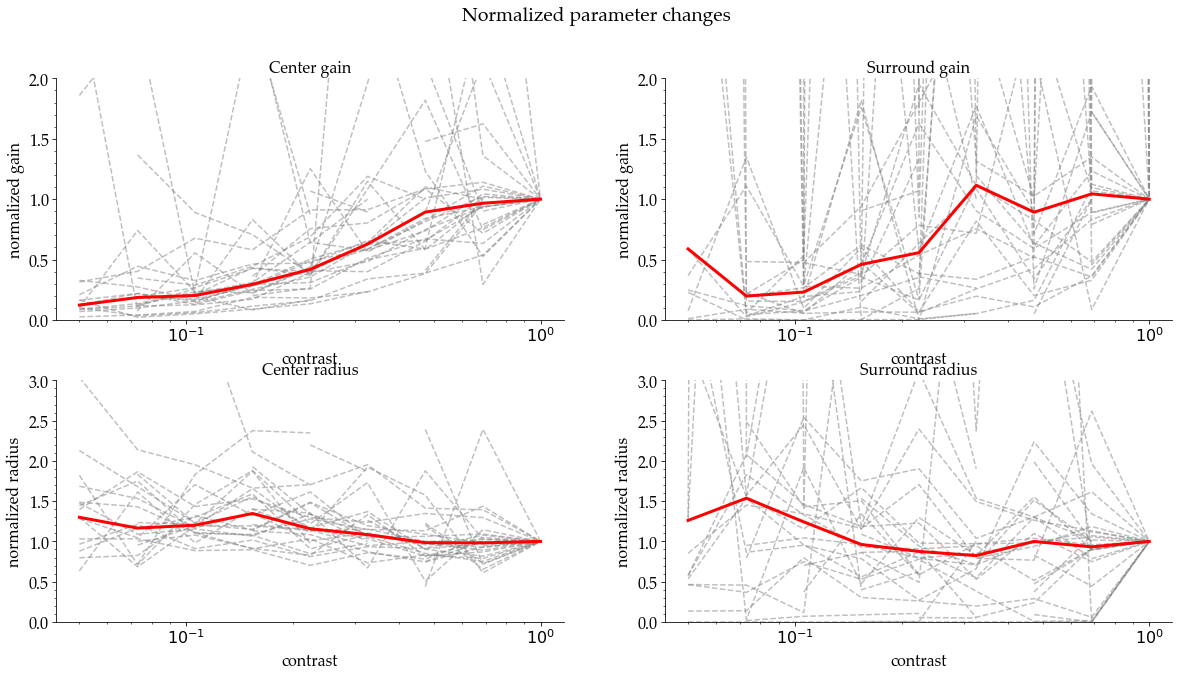

In [737]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

gray = cm.gray(0.5)

# center gain
plt.subplot(2, 2, 1);
con_inds = np.where(~np.isnan(all_gc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_gc_norm[i, con_inds][0], '--', c=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc_norm, 0);
plt.plot(val_cons, gc_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Center gain')
plt.xscale('log')

# surround gain
plt.subplot(2, 2, 2);
con_inds = np.where(~np.isnan(all_gs[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_gs_norm[i, con_inds][0], '--', c=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs_norm, 0);
plt.plot(val_cons, gs_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Surround gain')
plt.xscale('log')

# center freq
plt.subplot(2, 2, 3);
con_inds = np.where(~np.isnan(all_rc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rc_norm[i, con_inds][0], '--', c=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 3]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Center radius')
plt.xscale('log')

# surround freq
plt.subplot(2, 2, 4);
con_inds = np.where(~np.isnan(all_rs[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rs_norm[i, con_inds][0], '--', c=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 3]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Normalized parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

saveName = "/DoG_params_norm.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Now, a more clear picture emerges: gain increases with contrast, and radius - both center and surround - decrease with contrast. This is what Sach finds (plots/reports only on the radius change).

### Reproduce Sach's figure 3-3

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


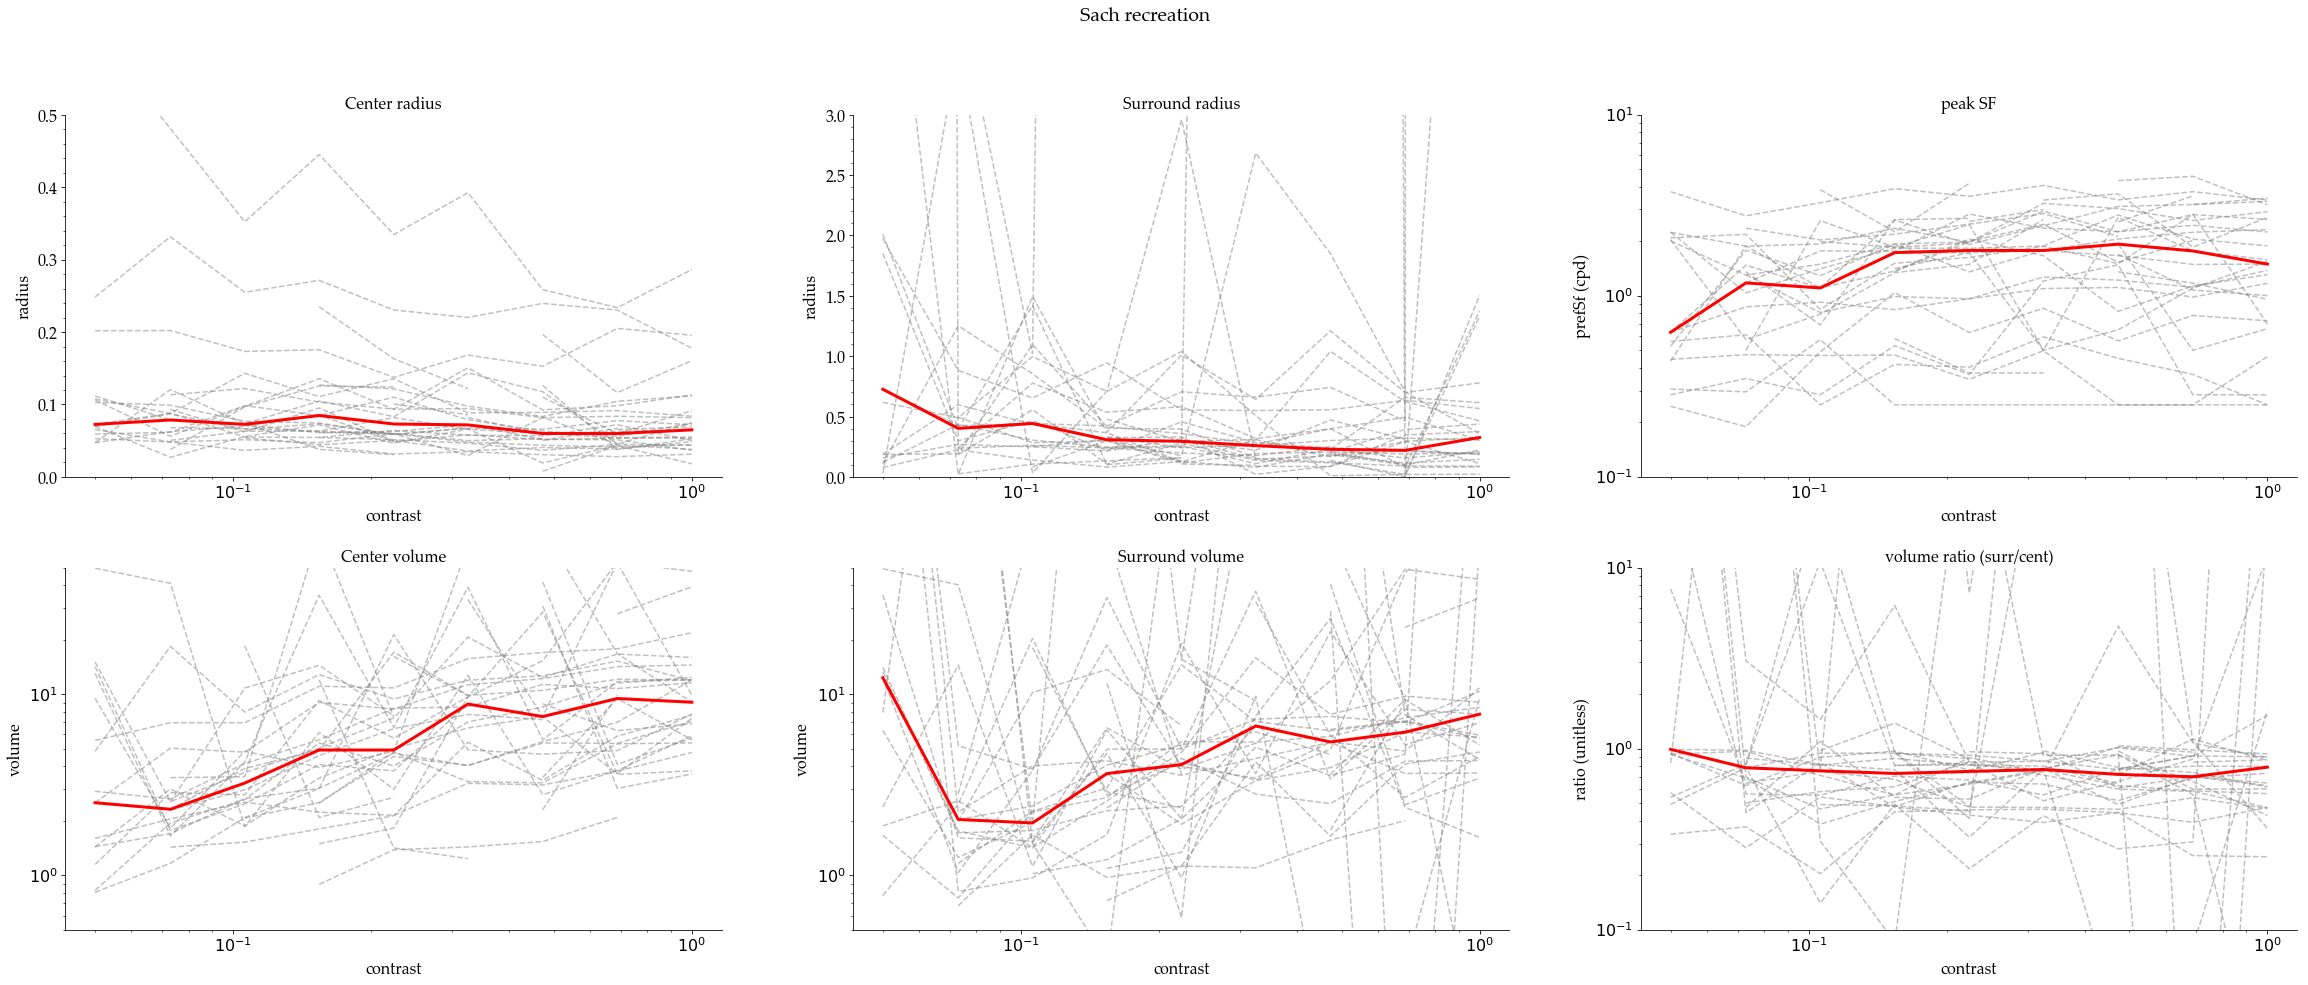

In [738]:
f, ax = plt.subplots(2, 3, figsize=(40, 15))

gray = cm.gray(0.5) # mean gray

# center freq
plt.subplot(2, 3, 1);
con_inds = np.where(~np.isnan(all_rc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rc[i, con_inds][0], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 0.5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround freq
plt.subplot(2, 3, 2);
con_inds = np.where(~np.isnan(all_rs[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rs[i, con_inds][0], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 3]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
con_inds = np.where(~np.isnan(all_psf[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_psf[i, con_inds][0], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf, 0);
plt.plot(val_cons, psf_medians[con_inds], 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
con_inds = np.where(~np.isnan(all_volc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_volc[i, con_inds][0], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc, 0);
plt.plot(val_cons, vc_medians[con_inds], 'r', linewidth=3)
plt.ylim([5e-1, 5e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
con_inds = np.where(~np.isnan(all_vols[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_vols[i, con_inds][0], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols, 0);
plt.plot(val_cons, vs_medians[con_inds], 'r', linewidth=3)
plt.ylim([5e-1, 5e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
con_inds = np.where(~np.isnan(all_volrat[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_volrat[i, con_inds][0], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat, 0);
plt.plot(val_cons, volrat_medians[con_inds], 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation')
f.subplots_adjust(wspace=0.2, hspace=0.25);

saveName = "/sach.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Now, the normalized version

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


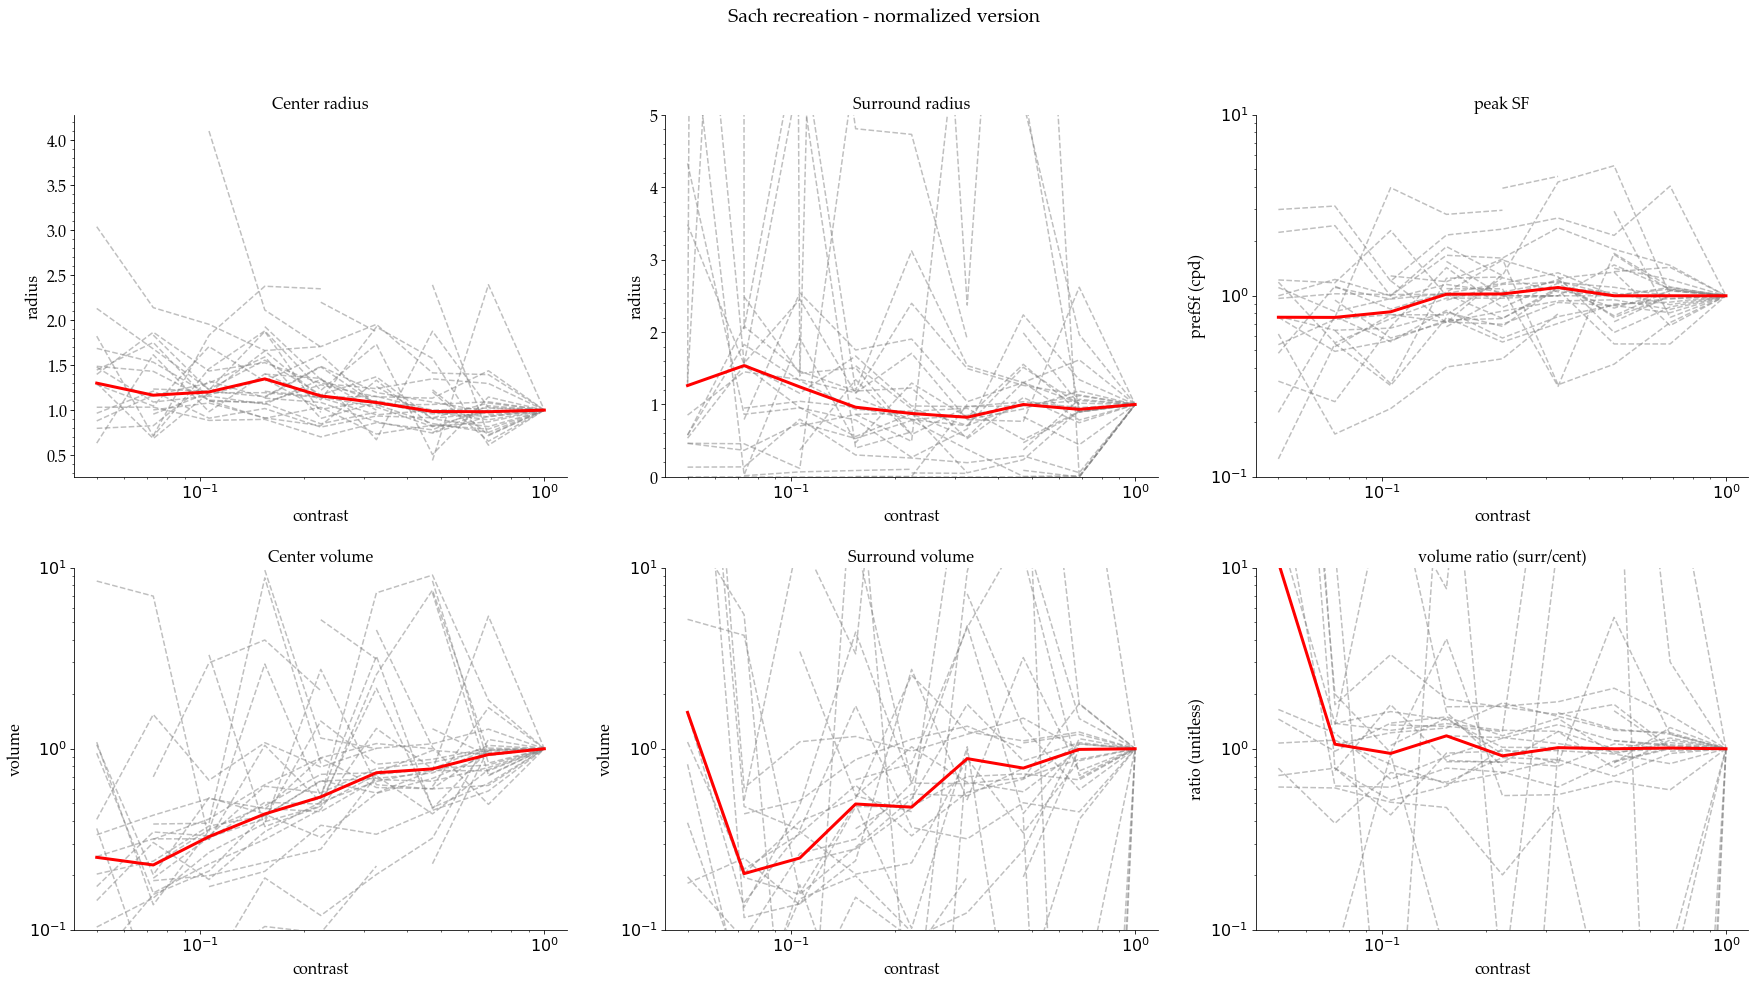

In [739]:
f, ax = plt.subplots(2, 3, figsize=(30, 15))

gray = cm.gray(0.5) # mean gray

# center freq
plt.subplot(2, 3, 1);
con_inds = np.where(~np.isnan(all_rc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rc_norm[i, con_inds][0], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians[con_inds], 'r', linewidth=3)
# plt.ylim([0, 1]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround freq
plt.subplot(2, 3, 2);
con_inds = np.where(~np.isnan(all_rs[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_rs_norm[i, con_inds][0], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians[con_inds], 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
con_inds = np.where(~np.isnan(all_psf[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_psf_norm[i, con_inds][0], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf_norm, 0);
plt.plot(val_cons, psf_medians[con_inds], 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
con_inds = np.where(~np.isnan(all_volc[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_volc_norm[i, con_inds][0], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc_norm, 0);
plt.plot(val_cons, vc_medians[con_inds], 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
con_inds = np.where(~np.isnan(all_vols[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_vols_norm[i, con_inds][0], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols_norm, 0);
plt.plot(val_cons, vs_medians[con_inds], 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
con_inds = np.where(~np.isnan(all_volrat[0, :])) # same for all cells
val_cons = allCons[con_inds]
for i in range(n_cells):
    plt.plot(val_cons, all_volrat_norm[i, con_inds][0], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat_norm, 0);
plt.plot(val_cons, volrat_medians[con_inds], 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation - normalized version')
f.subplots_adjust(wspace=0.2, hspace=0.25);

saveName = "/sach_norm.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Compute and plot peak SF

In [700]:
# peak SF v. contrast
psf_geo = np.nan * np.zeros((n_cons, ))
psf_norm_geo = np.nan * np.zeros((n_cons, ))
for i in range(n_cons):
    non_nans = np.where(~np.isnan(all_psf[:, i]))[0]
    if len(non_nans) > 0:
        psf_geo[i] = geomean(all_psf[non_nans, i])
        psf_norm_geo[i] = geomean(all_psf_norm[non_nans, i])

# ratio of peak SF at high:low contrast
psf_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    psf_ratios[i, 0], _, _ = hf.dog_prefSfMod(descrFits[i], allCons)
    if dataList['unitType'][i] == 'parvo':
        psf_ratios[i, 1], _, _ = hf.dog_prefSfMod(descrFits[i], allCons)
    if dataList['unitType'][i] == 'magno':
        psf_ratios[i, 2], _, _ = hf.dog_prefSfMod(descrFits[i], allCons)
    if dataList['unitType'][i] == 'tbd':
        psf_ratios[i, 3], _, _ = hf.dog_prefSfMod(descrFits[i], allCons)

val_ratios_all = psf_ratios[~np.isnan(psf_ratios[:, 0]), 0]
val_ratios_p = psf_ratios[~np.isnan(psf_ratios[:, 1]), 1]
val_ratios_m = psf_ratios[~np.isnan(psf_ratios[:, 2]), 2]
val_ratios_tbd = psf_ratios[~np.isnan(psf_ratios[:, 3]), 3]

/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/functions/helper_fcns.py:528: RuntimeWarning: invalid value encountered in greater
  validInds = np.where(descrFit['varExpl'][disp, :] > varThresh)[0];
/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/functions/helper_fcns.py:539: RuntimeWarning: invalid value encountered in double_scalars
  # run


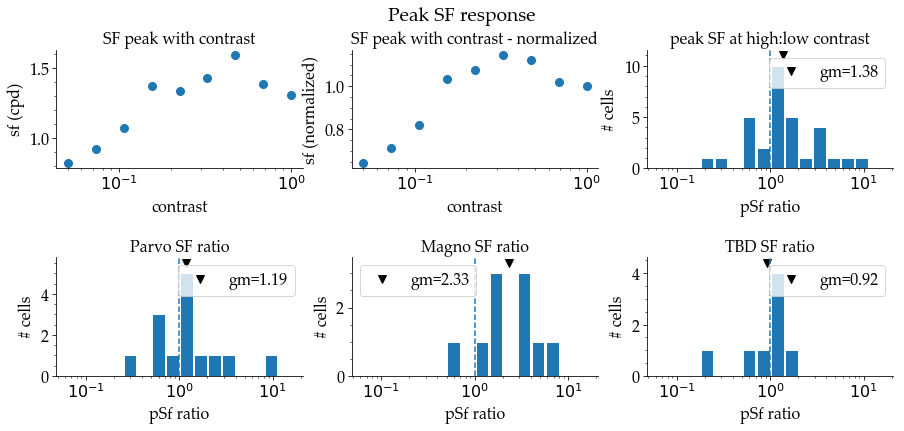

In [740]:
nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow))

plt.subplot(nrow, ncol, 1)
plt.plot(allCons, psf_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (cpd)')
plt.title('SF peak with contrast');

plt.subplot(nrow, ncol, 2)
plt.plot(allCons, psf_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('SF peak with contrast - normalized');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log')
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('peak SF at high:low contrast')
plt.legend();

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log')
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('Parvo SF ratio')
plt.legend();

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log')
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('Magno SF ratio')
plt.legend();

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_tbd)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log')
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('TBD SF ratio')
plt.legend();

f.suptitle('Peak SF response')
f.subplots_adjust(wspace=0.2, hspace=0.75);

saveName = "/peakSF.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Relating SF tuning to gain control

We can use phase advance as a proxy for strength of gain control, and relate phase advance to the change in peak contrast, for example

In [684]:
meanPhAdv =[np.nanmean(phFits[x]['phAdv']) for x in phFits]
bestPhAdv =[np.nanmax(phFits[x]['phAdv']) for x in phFits]

meanConGain =[np.nanmean(rvcFits[x]['conGain']) for x in phFits]
bestConGain =[np.nanmax(rvcFits[x]['conGain']) for x in phFits]

meanVarExpl = [np.nanmean(descrFits[x]['varExpl'][0, :]) for x in descrFits]
varAsInd = np.round(meanVarExpl).astype('int32')
varRange = np.max(varAsInd) - np.min(varAsInd);

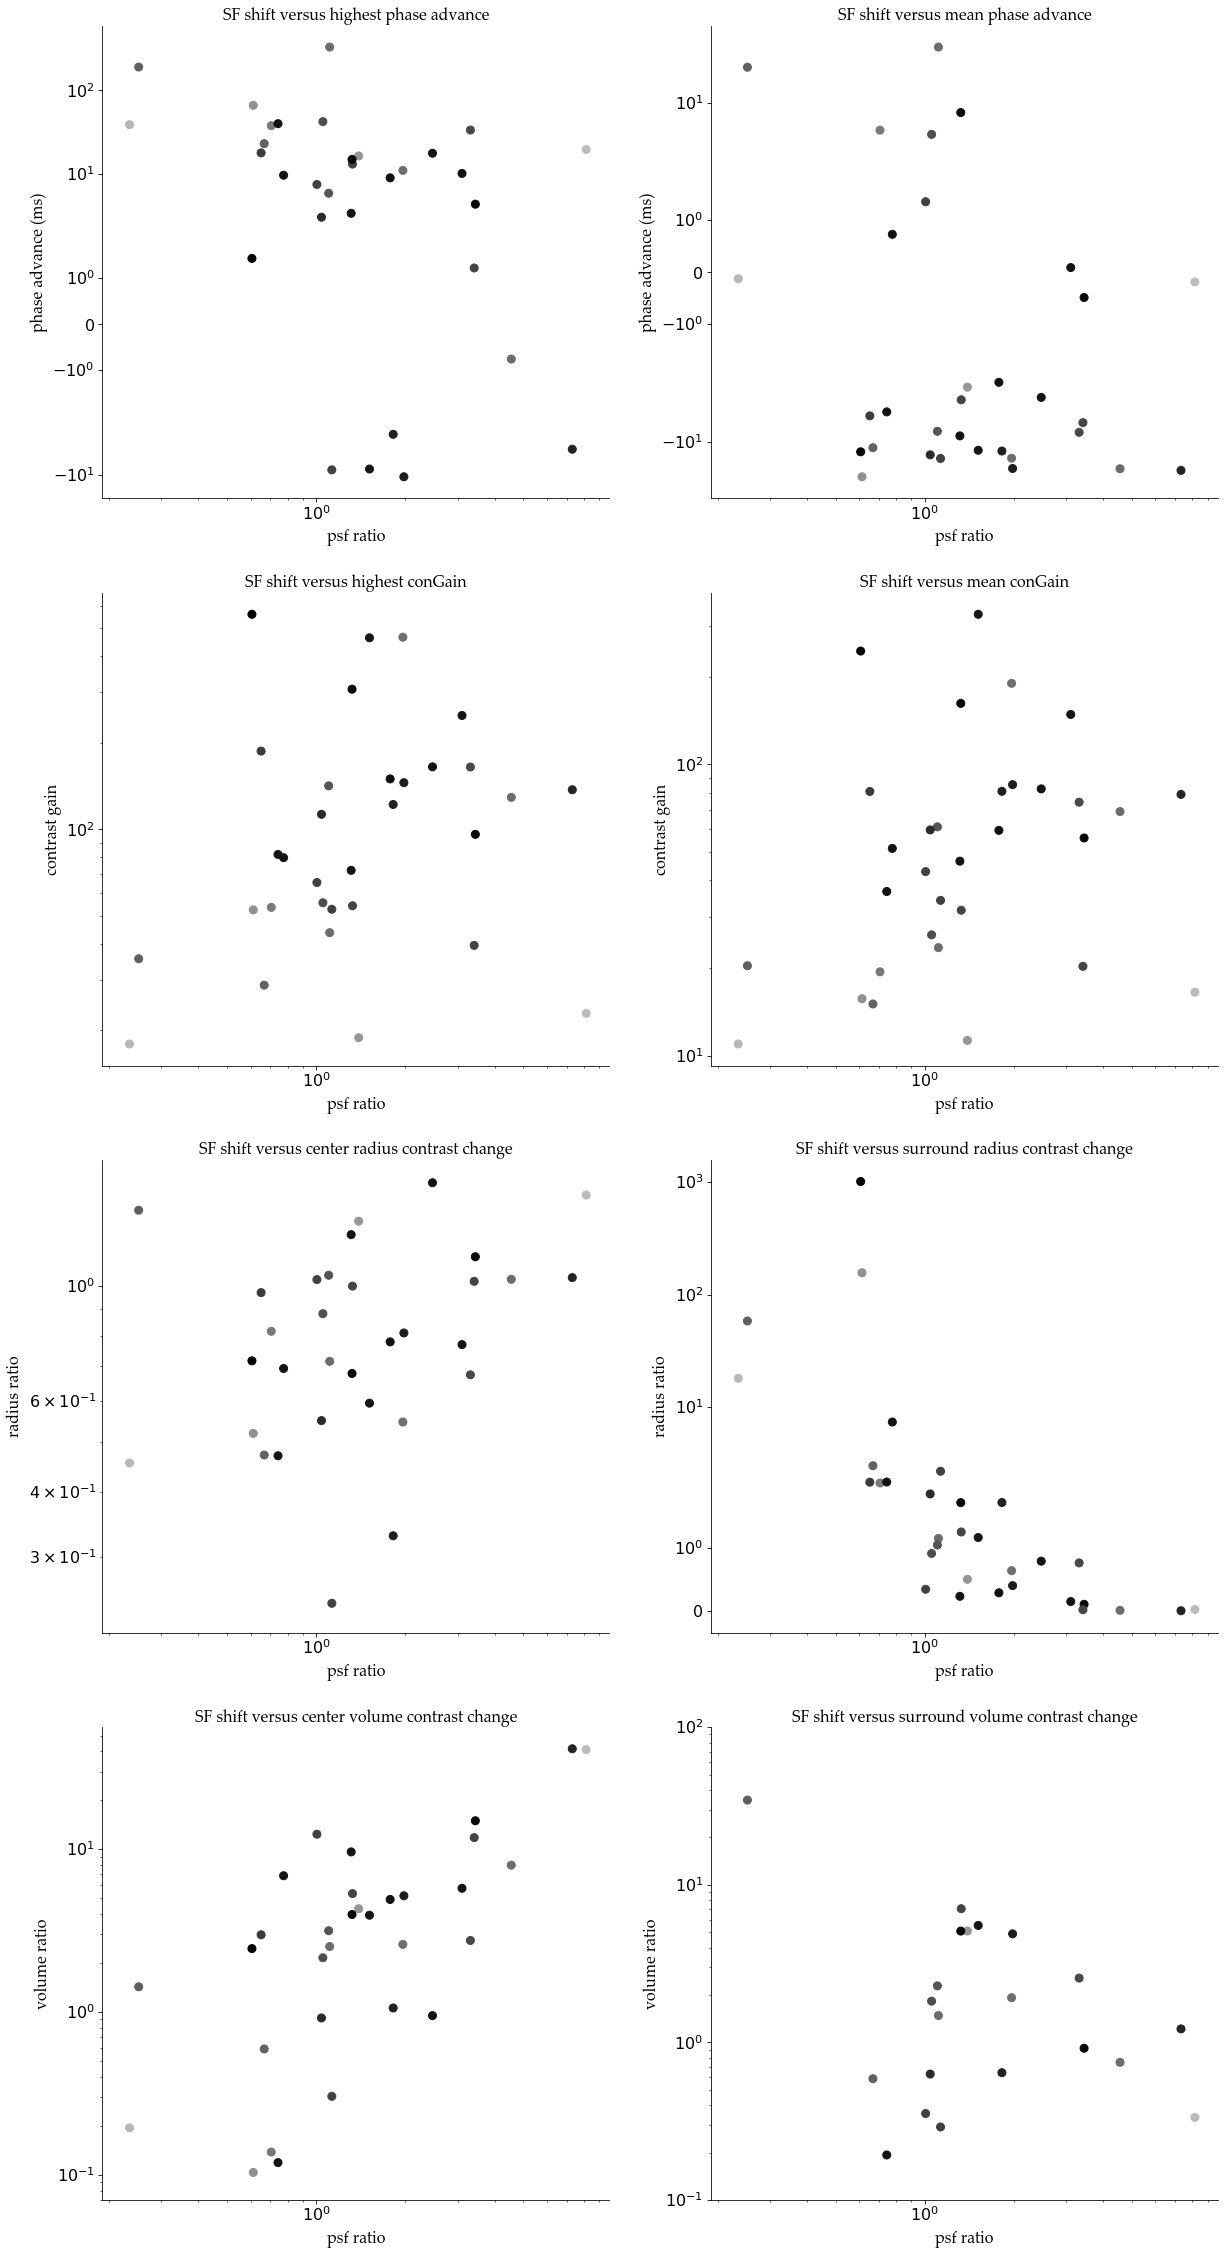

In [743]:
nrow = 4;
ncol = 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*10))

### pSf versus phase advance

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 1)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], bestPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('symlog')
plt.ylabel('phase advance (ms)');
plt.title('SF shift versus highest phase advance');
# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 2)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], meanPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('symlog')
plt.ylabel('phase advance (ms)');
plt.title('SF shift versus mean phase advance');

### pSf versus contrast gain

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 3)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], bestConGain, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('contrast gain');
plt.title('SF shift versus highest conGain');

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 4)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], meanConGain, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('contrast gain');
plt.title('SF shift versus mean conGain');

### pSf versus center radius change (high:low contrast ratio)
plt.subplot(nrow, ncol, 5)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_rc_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('radius ratio');
plt.title('SF shift versus center radius contrast change');

### pSf versus surround radius change
# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 6)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_rs_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('symlog')
plt.ylabel('radius ratio');
plt.title('SF shift versus surround radius contrast change');

### pSf versus center volume change
plt.subplot(nrow, ncol, 7)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_volc_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('volume ratio');
plt.title('SF shift versus center volume contrast change');

### pSf versus surround volume change
# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 8)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_vols_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.ylim([1e-1, 1e2])
plt.yscale('log')
plt.ylabel('volume ratio');
plt.title('SF shift versus surround volume contrast change');

saveName = "/peakSF_v_DoG.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()